# AI Assistant

Ali HajiSadeghi

Alireza Nobakht 402203559

## Preprocessing

In [1]:
!pip install transformers[torch] datasets evaluate seqeval hmmlearn

     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     --------- ------------------------------ 10.2/43.6 kB ? eta -:--:--
     -------------------------------------- 43.6/43.6 kB 709.9 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     --------- ------------------------------ 10.2/43.6 kB ? eta -:--:--
     -------------------------------------- 43.6/43.6 kB 725.8 kB/s eta 0:00:00
  Using cached regex-2024.5.15-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached aiohttp-3.9.5-cp311-cp311


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\Ali\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import libraries

In [1]:
import random

import numpy as np
import pandas as pd

### Make results reproducible

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)

### Load train and test datasets

you should give the path to `train.csv` and `test.csv`. you can download them from this [Link]('https://www.kaggle.com/datasets/halflingwizard/persian-questions')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [4]:
train_path = 'train.csv'
train_df = pd.read_csv(train_path)
train_df['words_split'] = train_df['words'].apply(lambda x: x.split())
train_df['label_split'] = train_df['words_label'].apply(lambda x: x.split())
train_df.head()

,Unnamed: 0,words,words_label,intent_label,words_split,label_split
0,0,آب و هوا ابریه,O O O O,Get_Weather,"[آب, و, هوا, ابریه]","[O, O, O, O]"
1,1,از میدان نقش جهان تا مدرسه هزینه چند ریال م...,O B-Departure I-Departure I-Departure O B-Dest...,Catch_a_Cab,"[از, میدان, نقش, جهان, تا, مدرسه, هزینه, چند, ...","[O, B-Departure, I-Departure, I-Departure, O, ..."
2,2,پسفردا درجه هوا در اهواز چقدر است,B-Date O O O B-Location O O,Get_Weather,"[پسفردا, درجه, هوا, در, اهواز, چقدر, است]","[B-Date, O, O, O, B-Location, O, O]"
3,3,میخوام برای میان وعده چهار تا هات داگ از ن...,O O O O B-Number I-Number B-Food I-Food O B-Re...,Order_Food,"[میخوام, برای, میان, وعده, چهار, تا, هات, داگ,...","[O, O, O, O, B-Number, I-Number, B-Food, I-Foo..."
4,4,یک عدد تاکسی میخوام که برم میدان نقش جهان,O O O O O O B-Destination I-Destination I-Dest...,Catch_a_Cab,"[یک, عدد, تاکسی, میخوام, که, برم, میدان, نقش, ...","[O, O, O, O, O, O, B-Destination, I-Destinatio..."


In [7]:
test_path = 'test.csv'
test_df = pd.read_csv(test_path)
test_df['words_split'] = test_df['words'].apply(lambda x: x.split())
test_df['label_split'] = test_df['words_label'].apply(lambda x: x.split())
test_df.head()

,Unnamed: 0,words,words_label,intent_label,words_split,label_split
0,500,تا تهرانپارس میخوام آژانس بگیرم,O B-Destination O O O,Catch_a_Cab,"[تا, تهرانپارس, میخوام, آژانس, بگیرم]","[O, B-Destination, O, O, O]"
1,501,میشه از رستوران ارکید برای ناهار یه دونه سال...,O O B-Restaurant I-Restaurant O O B-Number I-N...,Order_Food,"[میشه, از, رستوران, ارکید, برای, ناهار, یه, دو...","[O, O, B-Restaurant, I-Restaurant, O, O, B-Num..."
2,502,من یک عدد کباب برگ از نزدیک ترین کافه میخوام,O B-Number I-Number B-Food I-Food O B-Restaura...,Order_Food,"[من, یک, عدد, کباب, برگ, از, نزدیک, ترین, کافه...","[O, B-Number, I-Number, B-Food, I-Food, O, B-R..."
3,503,لطفا از رستوران ارکید برای میان وعده یه دونه...,O O B-Restaurant I-Restaurant O O O B-Number I...,Order_Food,"[لطفا, از, رستوران, ارکید, برای, میان, وعده, ی...","[O, O, B-Restaurant, I-Restaurant, O, O, O, B-..."
4,504,بهترین ترانه هفته را پخش کن,O O O O O O,Play_Music,"[بهترین, ترانه, هفته, را, پخش, کن]","[O, O, O, O, O, O]"


For document classification we need to have cross validation:

In [15]:
train_len = len(train_df)
cv_len = int(train_len * 0.1)
train_df = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)
train_cv_df = train_df[:cv_len]
train_main_df = train_df[cv_len:]
train_main_df.head()

,Unnamed: 0,words,words_label,intent_label,words_split,label_split
50,72,هوا چطوره,O O,Get_Weather,"[هوا, چطوره]","[O, O]"
51,182,لطفا یه ترانه از مایکل جکسون بذار,O O O O B-Artist I-Artist O,Play_Music,"[لطفا, یه, ترانه, از, مایکل, جکسون, بذار]","[O, O, O, O, B-Artist, I-Artist, O]"
52,131,لطفا یه دونه ماشین بگیر من رو ببره تجریش,O O O O O O O O B-Destination,Catch_a_Cab,"[لطفا, یه, دونه, ماشین, بگیر, من, رو, ببره, تج...","[O, O, O, O, O, O, O, O, B-Destination]"
53,410,شادترین ترانه سال 2020 را پخش کن,O O O O O O O,Play_Music,"[شادترین, ترانه, سال, 2020, را, پخش, کن]","[O, O, O, O, O, O, O]"
54,193,لطفا آهنگی از شماعی زاده پخش کن,O O O B-Artist I-Artist O O,Play_Music,"[لطفا, آهنگی, از, شماعی, زاده, پخش, کن]","[O, O, O, B-Artist, I-Artist, O, O]"


In [12]:
train_cv_df.head()

,Unnamed: 0,words,words_label,intent_label,words_split,label_split
0,361,واسه من یه دونه اسنپ بگیر تا دانشگاه شریف,O O O O O O O B-Destination I-Destination,Catch_a_Cab,"[واسه, من, یه, دونه, اسنپ, بگیر, تا, دانشگاه, ...","[O, O, O, O, O, O, O, B-Destination, I-Destina..."
1,73,اسنپ از دانشگاه علم و صنعت تا دانشگاه علم و...,O O B-Departure I-Departure I-Departure I-Depa...,Catch_a_Cab,"[اسنپ, از, دانشگاه, علم, و, صنعت, تا, دانشگاه,...","[O, O, B-Departure, I-Departure, I-Departure, ..."
2,374,یه دونه کباب برگ سفارش بده,B-Number I-Number B-Food I-Food O O,Order_Food,"[یه, دونه, کباب, برگ, سفارش, بده]","[B-Number, I-Number, B-Food, I-Food, O, O]"
3,155,یه ترانه زیبا از یاس پخش کن,O O O O B-Artist O O,Play_Music,"[یه, ترانه, زیبا, از, یاس, پخش, کن]","[O, O, O, O, B-Artist, O, O]"
4,104,هزینه چهار تا چلوکباب از رستوران بیست چقدر...,O B-Number I-Number B-Food O B-Restaurant I-Re...,Order_Food,"[هزینه, چهار, تا, چلوکباب, از, رستوران, بیست, ...","[O, B-Number, I-Number, B-Food, O, B-Restauran..."


## Token Classification

### Base Model

We will use Hidden Markov Model for this part:

In [11]:
train_df.head()

,Unnamed: 0,words,words_label,intent_label,words_split,label_split
0,0,آب و هوا ابریه,O O O O,Get_Weather,"[آب, و, هوا, ابریه]","[O, O, O, O]"
1,1,از میدان نقش جهان تا مدرسه هزینه چند ریال م...,O B-Departure I-Departure I-Departure O B-Dest...,Catch_a_Cab,"[از, میدان, نقش, جهان, تا, مدرسه, هزینه, چند, ...","[O, B-Departure, I-Departure, I-Departure, O, ..."
2,2,پسفردا درجه هوا در اهواز چقدر است,B-Date O O O B-Location O O,Get_Weather,"[پسفردا, درجه, هوا, در, اهواز, چقدر, است]","[B-Date, O, O, O, B-Location, O, O]"
3,3,میخوام برای میان وعده چهار تا هات داگ از ن...,O O O O B-Number I-Number B-Food I-Food O B-Re...,Order_Food,"[میخوام, برای, میان, وعده, چهار, تا, هات, داگ,...","[O, O, O, O, B-Number, I-Number, B-Food, I-Foo..."
4,4,یک عدد تاکسی میخوام که برم میدان نقش جهان,O O O O O O B-Destination I-Destination I-Dest...,Catch_a_Cab,"[یک, عدد, تاکسی, میخوام, که, برم, میدان, نقش, ...","[O, O, O, O, O, O, B-Destination, I-Destinatio..."


In [20]:
all_labels = sorted(list(set([label for labels in train_df['label_split'] for label in labels])))
all_words = sorted(list(set([word for words in train_main_df['words_split'] for word in words] + ["<UKN>"])))

label2i = {label: i for i, label in enumerate(all_labels)}
word2i = {word: i for i, word in enumerate(all_words)}
i2label = {i: label for i, label in enumerate(all_labels)}
i2word = {i: word for i, word in enumerate(all_words)}
def l2i(lable):
    return label2i[label]
def i2l(i):
    return i2label[i]
def w2i(word):
    if word in word2i:
        return word2i[word]
    return word2i['<UKN>']
def i2w(i):
    return i2word[i]

state_transition = np.zeros((len(all_labels), len(all_labels)))
emission_prob = np.zeros((len(all_labels), len(all_words)))
start_prob = np.zeros(len(all_labels))
end_prob = np.zeros(len(all_labels))

In [21]:
for row in range(len(train_main_df)):
    word_list = train_main_df['words_split'].iloc[row]
    label_list = train_main_df['label_split'].iloc[row]
    start_prob[label2i[label_list[0]]] += 1
    emission_prob[label2i[label_list[0]]][word2i[word_list[0]]] += 1
    for i in range(1,len(word_list)):
        state_transition[label2i[label_list[i-1]]][label2i[label_list[i]]] += 1
        emission_prob[label2i[label_list[i]]][word2i[word_list[i]]] += 1

emission_prob[:][word2i['<UKN>']] = 1


In [22]:
start_prob = start_prob / np.sum(start_prob)
state_transition /= np.sum(state_transition, axis=0, keepdims=True)
emission_prob /= np.sum(emission_prob, axis=0, keepdims=True)

In [25]:
eps = 1e-6
def viterbi(word_seq):
    dp = []
    dp_path = []
    temp = np.zeros(len(all_labels))
    for label in all_labels:
        i = label2i[label]
        temp[i] = np.log(eps+start_prob[i]) + np.log(eps+emission_prob[i][w2i(word_seq[0])])
    dp.append(temp)
    dp_path.append([None]*len(all_labels))
    for i in range(1,len(word_seq)):
        temp = np.zeros(len(all_labels))
        temp_path = [0] * len(all_labels)
        for label in all_labels:
            l = label2i[label]
            best = -1e30
            best_pre = None
            for label_prim in all_labels:
                l_prim = label2i[label_prim]
                curr_logprob = dp[i-1][l_prim] + np.log(eps+state_transition[l_prim][l]) + np.log(eps+emission_prob[l][w2i(word_seq[i])])
                if best < curr_logprob:
                    best = curr_logprob
                    best_pre = l_prim
            temp[l] = best
            temp_path[l] = best_pre
        dp.append(temp)
        dp_path.append(temp_path)


    mx = np.argmax(dp[-1])
    path = [mx,]
    for i in range(len(dp_path)-2,-1,-1):
        path.append(dp_path[i+1][path[-1]])
    return list(reversed([i2l(p) for p in path]))


In [27]:
viterbi("یه ترانه زیبا از یاس پخش کن".split())

['O', 'O', 'O', 'O', 'B-Artist', 'O', 'O']

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from seqeval.metrics import f1_score

pred_labels = [pred for pred in test_df['words_split'].apply(viterbi)]
true_labels = test_df['label_split'].tolist()

flat_pred_labels = [token for sublist in pred_labels for token in sublist]
flat_true_labels = [token for sublist in true_labels for token in sublist]

f1_micro = f1_score([flat_true_labels], [flat_pred_labels], average='micro')
f1_macro = f1_score([flat_true_labels], [flat_pred_labels], average='macro')
accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
classification_rep = classification_report(flat_true_labels, flat_pred_labels)
conf_matrix = confusion_matrix(flat_true_labels, flat_pred_labels)

print(f"F1 Micro: {f1_micro}")
print(f"F1 Macro: {f1_macro}")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

F1 Micro: 0.8814432989690721
F1 Macro: 0.8261301403724158
Accuracy: 0.9591836734693877
Classification Report:
                precision    recall  f1-score   support

     B-Artist       1.00      0.96      0.98        25
       B-Date       1.00      1.00      1.00        21
  B-Departure       0.17      0.08      0.11        12
B-Destination       0.69      0.77      0.73        31
       B-Food       0.88      1.00      0.94        29
   B-Location       0.95      0.86      0.90        22
     B-Number       0.91      1.00      0.95        29
 B-Restaurant       1.00      1.00      1.00        24
     I-Artist       1.00      1.00      1.00        18
       I-Date       1.00      1.00      1.00        15
  I-Departure       0.20      0.12      0.15         8
I-Destination       0.75      0.68      0.71        31
       I-Food       0.95      1.00      0.98        20
   I-Location       0.00      0.00      0.00         3
     I-Number       1.00      1.00      1.00        24
 I-Resta

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

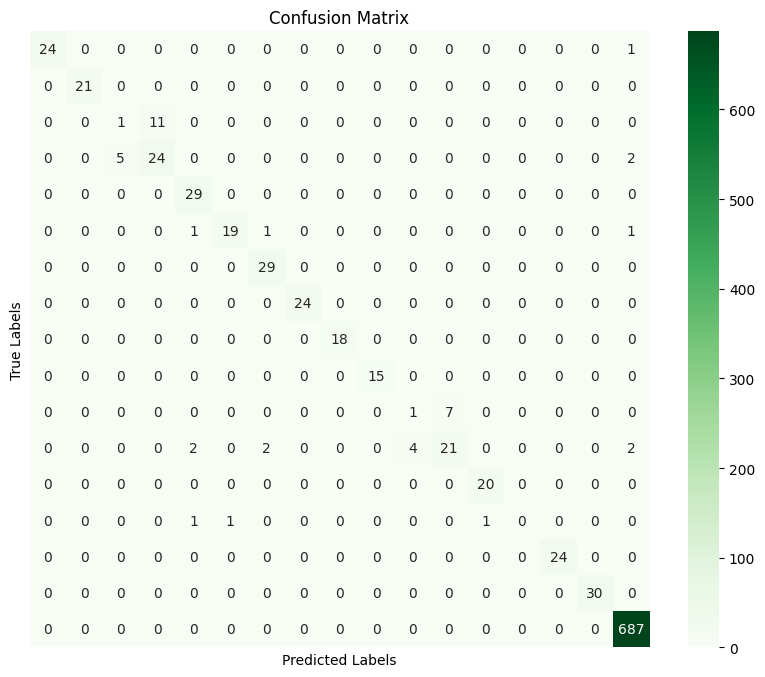

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[], yticklabels=[])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Main Model

In [32]:
labels = sorted(list(set([y for x in train_df["label_split"].tolist() for y in x])))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

In [33]:
# Load model directly
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", num_labels=len(labels))

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ali\.cache\huggingface\hub\models--HooshvareLab--bert-fa-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
x_main_encoded = [tokenizer(text, return_tensors='pt', is_split_into_words=True) for text in train_main_df["words_split"].tolist()]
y_main_encoded = [[label2id[label] for label in labels] for labels in train_main_df["label_split"].tolist()]
x_cv_encoded = [tokenizer(text, return_tensors='pt', is_split_into_words=True) for text in train_cv_df["words_split"].tolist()]
y_cv_encoded = [[label2id[label] for label in labels] for labels in train_cv_df["label_split"].tolist()]
x_test_encoded = [tokenizer(text, return_tensors='pt', is_split_into_words=True) for text in test_df["words_split"].tolist()]
y_test_encoded = [[label2id[label] for label in labels] for labels in test_df["label_split"].tolist()]

In [35]:
x_main_encoded[1]['input_ids'].shape, len(y_main_encoded[1])

(torch.Size([1, 9]), 7)

In [36]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [37]:
from datasets import Dataset, DatasetDict

train_main_data = {"tokens": [text for text in train_main_df['words_split'].tolist()], "labels": y_main_encoded}
train_cv_data = {"tokens": [text for text in train_cv_df['words_split'].tolist()], "labels": y_cv_encoded}
test_data = {"tokens": [text for text in test_df['words_split'].tolist()], "labels": y_test_encoded}

train_main_dataset = Dataset.from_dict(train_main_data)
train_cv_dataset = Dataset.from_dict(train_cv_data)
test_dataset = Dataset.from_dict(test_data)

com_dataset = DatasetDict({"train": train_main_dataset, "validation": train_cv_dataset, "test": test_dataset})

In [38]:
tokenized_datasets = com_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_datasets

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 450
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
    test: Dataset({
        features: ['tokens', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 122
    })
})

In [39]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [40]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased",
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-fa-finetuned-tokenization",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }


In [43]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [44]:
trainer.train()

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.2059686183929443, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.629976580796253, 'eval_runtime': 0.4796, 'eval_samples_per_second': 104.25, 'eval_steps_per_second': 2.085, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6839259266853333, 'eval_precision': 0.5909090909090909, 'eval_recall': 0.4588235294117647, 'eval_f1': 0.5165562913907285, 'eval_accuracy': 0.8360655737704918, 'eval_runtime': 0.4852, 'eval_samples_per_second': 103.057, 'eval_steps_per_second': 2.061, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.38483133912086487, 'eval_precision': 0.7738095238095238, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7692307692307693, 'eval_accuracy': 0.9250585480093677, 'eval_runtime': 0.4452, 'eval_samples_per_second': 112.3, 'eval_steps_per_second': 2.246, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.20844949781894684, 'eval_precision': 0.8351648351648352, 'eval_recall': 0.8941176470588236, 'eval_f1': 0.8636363636363636, 'eval_accuracy': 0.9578454332552693, 'eval_runtime': 0.454, 'eval_samples_per_second': 110.138, 'eval_steps_per_second': 2.203, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.11707894504070282, 'eval_precision': 0.898876404494382, 'eval_recall': 0.9411764705882353, 'eval_f1': 0.9195402298850575, 'eval_accuracy': 0.9718969555035128, 'eval_runtime': 0.4558, 'eval_samples_per_second': 109.693, 'eval_steps_per_second': 2.194, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.07365971803665161, 'eval_precision': 0.8791208791208791, 'eval_recall': 0.9411764705882353, 'eval_f1': 0.9090909090909091, 'eval_accuracy': 0.9789227166276346, 'eval_runtime': 0.4585, 'eval_samples_per_second': 109.045, 'eval_steps_per_second': 2.181, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.04906756803393364, 'eval_precision': 0.9651162790697675, 'eval_recall': 0.9764705882352941, 'eval_f1': 0.9707602339181286, 'eval_accuracy': 0.9953161592505855, 'eval_runtime': 0.462, 'eval_samples_per_second': 108.233, 'eval_steps_per_second': 2.165, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.03760933876037598, 'eval_precision': 0.9651162790697675, 'eval_recall': 0.9764705882352941, 'eval_f1': 0.9707602339181286, 'eval_accuracy': 0.9953161592505855, 'eval_runtime': 0.4427, 'eval_samples_per_second': 112.952, 'eval_steps_per_second': 2.259, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.03207265958189964, 'eval_precision': 0.9651162790697675, 'eval_recall': 0.9764705882352941, 'eval_f1': 0.9707602339181286, 'eval_accuracy': 0.9953161592505855, 'eval_runtime': 0.4615, 'eval_samples_per_second': 108.332, 'eval_steps_per_second': 2.167, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.030617741867899895, 'eval_precision': 0.9651162790697675, 'eval_recall': 0.9764705882352941, 'eval_f1': 0.9707602339181286, 'eval_accuracy': 0.9953161592505855, 'eval_runtime': 0.4843, 'eval_samples_per_second': 103.233, 'eval_steps_per_second': 2.065, 'epoch': 10.0}
{'train_runtime': 215.9187, 'train_samples_per_second': 20.841, 'train_steps_per_second': 0.371, 'train_loss': 0.397606635093689, 'epoch': 10.0}


TrainOutput(global_step=80, training_loss=0.397606635093689, metrics={'train_runtime': 215.9187, 'train_samples_per_second': 20.841, 'train_steps_per_second': 0.371, 'total_flos': 36569152824948.0, 'train_loss': 0.397606635093689, 'epoch': 10.0})

In [36]:
import torch
model.eval()

predictions = []
labels_all = []

with torch.no_grad():
    for tokens, labels in zip(x_test_encoded, tokenized_datasets['test']['labels']):
        outputs = model(**tokens.to('cuda'))
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        predictions.extend(preds.cpu().numpy())
        labels_all.append([label2id['O'] if l == -100 else l for l in labels])

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from seqeval.metrics import f1_score

pred_labels = [[id2label[id] for id in pred] for pred in predictions]
true_labels = [[id2label[id] for id in label] for label in labels_all]

flat_pred_labels = [token for sublist in pred_labels for token in sublist]
flat_true_labels = [token for sublist in true_labels for token in sublist]

f1_micro = f1_score([flat_true_labels], [flat_pred_labels], average='micro')
f1_macro = f1_score([flat_true_labels], [flat_pred_labels], average='macro')
accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
classification_rep = classification_report(flat_true_labels, flat_pred_labels)
conf_matrix = confusion_matrix(flat_true_labels, flat_pred_labels)

print(f"F1 Micro: {f1_micro}")
print(f"F1 Macro: {f1_macro}")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

F1 Micro: 0.906801007556675
F1 Macro: 0.9065336039463261
Accuracy: 0.983733539891557
Classification Report:
                precision    recall  f1-score   support

     B-Artist       1.00      1.00      1.00        25
       B-Date       0.77      0.95      0.85        21
  B-Departure       1.00      1.00      1.00        12
B-Destination       1.00      1.00      1.00        31
       B-Food       1.00      1.00      1.00        29
   B-Location       0.92      1.00      0.96        22
     B-Number       1.00      1.00      1.00        29
 B-Restaurant       0.96      1.00      0.98        24
     I-Artist       0.95      1.00      0.97        18
       I-Date       0.75      0.80      0.77        15
  I-Departure       1.00      1.00      1.00         8
I-Destination       0.97      1.00      0.98        31
       I-Food       0.91      1.00      0.95        20
   I-Location       0.00      0.00      0.00         3
     I-Number       1.00      1.00      1.00        24
 I-Restaur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


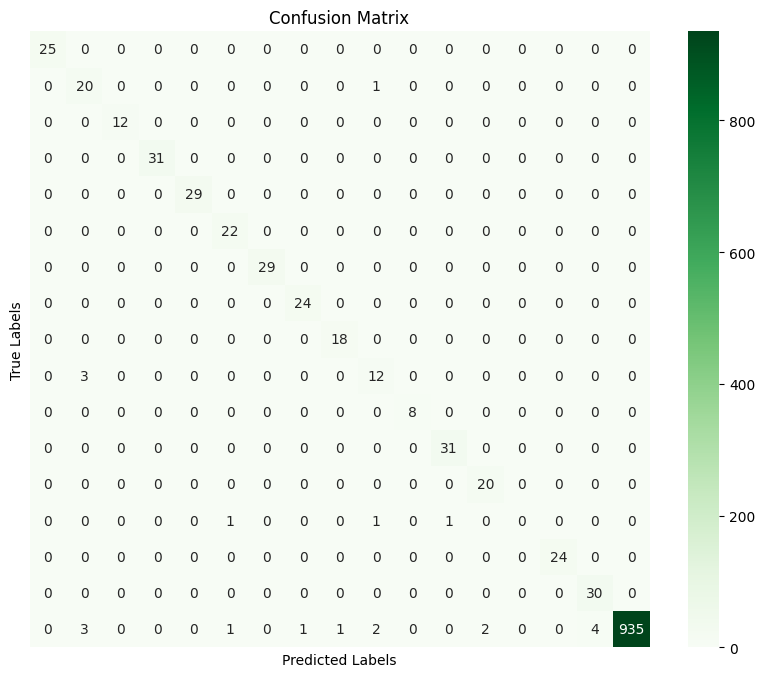

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[], yticklabels=[])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Document Classification

### Base Model

### Main Model

In [45]:
from datasets import Dataset
intent_labels = list(train_df["intent_label"].unique())
intent_label2id = {label: i for i, label in enumerate(intent_labels)}
id2intent_label = {i: label for i, label in enumerate(intent_labels)}

train_df["intent_label_encoded"] = train_df["intent_label"].apply(lambda x: intent_label2id[x])
train_main_df["intent_label_encoded"] = train_main_df["intent_label"].apply(lambda x: intent_label2id[x])
train_cv_df["intent_label_encoded"] = train_cv_df["intent_label"].apply(lambda x: intent_label2id[x])
test_df["intent_label_encoded"] = test_df["intent_label"].apply(lambda x: intent_label2id[x])


train_dataset = Dataset.from_pandas(train_df[["words", "intent_label_encoded"]].rename(columns={"words": "text", "intent_label_encoded": "label"}))
train_main_dataset = Dataset.from_pandas(train_main_df[["words", "intent_label_encoded"]].rename(columns={"words": "text", "intent_label_encoded": "label"}))
train_cv_dataset = Dataset.from_pandas(train_cv_df[["words","intent_label_encoded"]].rename(columns={"words": "text", "intent_label_encoded": "label"}))
test_dataset = Dataset.from_pandas(test_df[["words", "intent_label_encoded"]].rename(columns={"words": "text", "intent_label_encoded": "label"}))

C:\Users\Ali\AppData\Local\Temp\ipykernel_3260\2144494450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_main_df["intent_label_encoded"] = train_main_df["intent_label"].apply(lambda x: intent_label2id[x])
C:\Users\Ali\AppData\Local\Temp\ipykernel_3260\2144494450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cv_df["intent_label_encoded"] = train_cv_df["intent_label"].apply(lambda x: intent_label2id[x])


In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average='weighted')
    f1_micro = f1_metric.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average='macro')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1_micro': f1_micro['f1'],
        'f1_macro': f1_macro['f1'],
    }

In [48]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

encoded_train_main_dataset = train_main_dataset.map(preprocess_function, batched=True)
encoded_train_cv_dataset = train_cv_dataset.map(preprocess_function, batched=True)
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_main_dataset,
    eval_dataset=encoded_train_cv_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [49]:
trainer.train()

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.4657114744186401, 'eval_accuracy': 0.12, 'eval_precision': 0.03076923076923077, 'eval_recall': 0.12, 'eval_f1_micro': 0.12, 'eval_f1_macro': 0.061224489795918366, 'eval_runtime': 0.5016, 'eval_samples_per_second': 99.677, 'eval_steps_per_second': 1.994, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.3757448196411133, 'eval_accuracy': 0.22, 'eval_precision': 0.2622222222222222, 'eval_recall': 0.22, 'eval_f1_micro': 0.22, 'eval_f1_macro': 0.17132505175983437, 'eval_runtime': 0.4864, 'eval_samples_per_second': 102.803, 'eval_steps_per_second': 2.056, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.2202978134155273, 'eval_accuracy': 0.56, 'eval_precision': 0.6583928571428572, 'eval_recall': 0.56, 'eval_f1_micro': 0.56, 'eval_f1_macro': 0.5366010333752269, 'eval_runtime': 0.4844, 'eval_samples_per_second': 103.231, 'eval_steps_per_second': 2.065, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.0347840785980225, 'eval_accuracy': 0.82, 'eval_precision': 0.8280000000000001, 'eval_recall': 0.82, 'eval_f1_micro': 0.82, 'eval_f1_macro': 0.8088569088569089, 'eval_runtime': 0.471, 'eval_samples_per_second': 106.149, 'eval_steps_per_second': 2.123, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.8780754208564758, 'eval_accuracy': 0.9, 'eval_precision': 0.9152380952380952, 'eval_recall': 0.9, 'eval_f1_micro': 0.9, 'eval_f1_macro': 0.8884569377990431, 'eval_runtime': 0.48, 'eval_samples_per_second': 104.164, 'eval_steps_per_second': 2.083, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7440798878669739, 'eval_accuracy': 0.96, 'eval_precision': 0.9627777777777777, 'eval_recall': 0.96, 'eval_f1_micro': 0.96, 'eval_f1_macro': 0.9542097998619739, 'eval_runtime': 0.4862, 'eval_samples_per_second': 102.83, 'eval_steps_per_second': 2.057, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5896849632263184, 'eval_accuracy': 0.98, 'eval_precision': 0.9816666666666666, 'eval_recall': 0.98, 'eval_f1_micro': 0.98, 'eval_f1_macro': 0.9759725400457666, 'eval_runtime': 0.4955, 'eval_samples_per_second': 100.899, 'eval_steps_per_second': 2.018, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.4322153925895691, 'eval_accuracy': 0.98, 'eval_precision': 0.9816666666666666, 'eval_recall': 0.98, 'eval_f1_micro': 0.98, 'eval_f1_macro': 0.9759725400457666, 'eval_runtime': 0.4947, 'eval_samples_per_second': 101.073, 'eval_steps_per_second': 2.021, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.29236724972724915, 'eval_accuracy': 0.98, 'eval_precision': 0.9816666666666666, 'eval_recall': 0.98, 'eval_f1_micro': 0.98, 'eval_f1_macro': 0.9759725400457666, 'eval_runtime': 0.5097, 'eval_samples_per_second': 98.099, 'eval_steps_per_second': 1.962, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.18475939333438873, 'eval_accuracy': 0.98, 'eval_precision': 0.9816666666666666, 'eval_recall': 0.98, 'eval_f1_micro': 0.98, 'eval_f1_macro': 0.9759725400457666, 'eval_runtime': 0.5068, 'eval_samples_per_second': 98.649, 'eval_steps_per_second': 1.973, 'epoch': 10.0}
{'train_runtime': 195.6373, 'train_samples_per_second': 23.002, 'train_steps_per_second': 0.409, 'train_loss': 0.9373518943786621, 'epoch': 10.0}


TrainOutput(global_step=80, training_loss=0.9373518943786621, metrics={'train_runtime': 195.6373, 'train_samples_per_second': 23.002, 'train_steps_per_second': 0.409, 'total_flos': 36818736681168.0, 'train_loss': 0.9373518943786621, 'epoch': 10.0})

In [44]:
predictions = trainer.predict(encoded_test_dataset)
compute_metrics(predictions)

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_micro': 1.0,
 'f1_macro': 1.0}

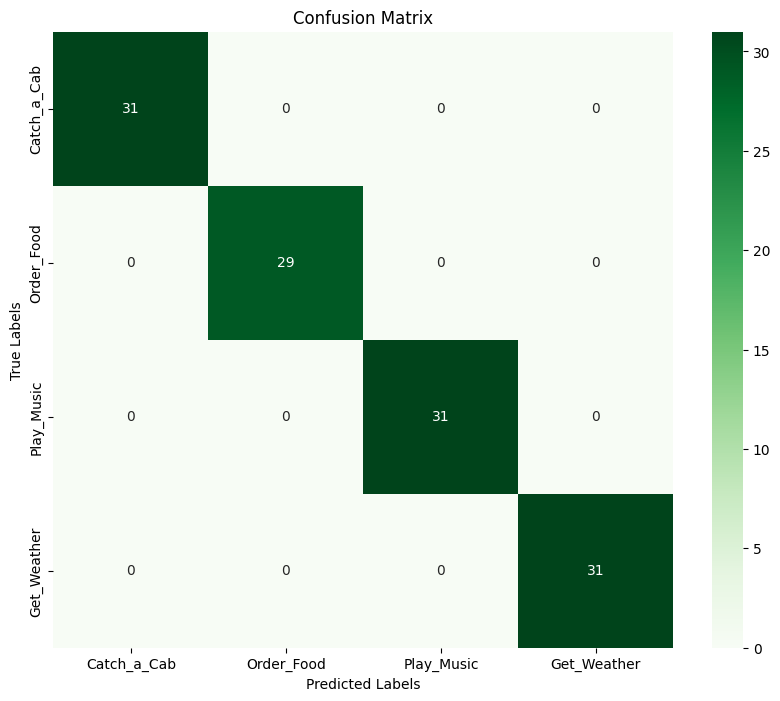

[[31  0  0  0]
 [ 0 29  0  0]
 [ 0  0 31  0]
 [ 0  0  0 31]]


In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = encoded_test_dataset['label']
y_pred = predictions.predictions.argmax(-1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[id2intent_label[i] for i in range(4)], yticklabels=[id2intent_label[i] for i in range(4)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)